In [1]:
# # Additional Code for Colab. Comment out if not using Colab.
# from google.colab import drive
# drive.mount('/content/drive')
#
# import sys
# sys.path.append('/content/drive/MyDrive/School/Fall 2022/COMP 5900')

import os, glob
import matplotlib.pyplot as plt

# ..........support imports............
from SupportClasses import Data_support as ds
from SupportClasses import TCAV_support as ts
from SupportClasses import Model_support as ms

# ..........torch imports............
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# .... Captum imports..................
from captum.attr import LayerIntegratedGradients
from captum.concept import TCAV

# GLobal values
COLAB = False
NUM_OF_EPOCHS = 25
IMAGENET_IND_DICT = {'ants': 310, 'bees': 309, 'zebra':340}
CONCEPTS_PATH = "data/tcav/image/concepts/"
DATA_DIR = 'data/tcav/image/imagenet'
# End of Global values



# Modifiable Values
TARGET_CONCEPT = "striped"
TARGET_CLASS = "zebra"
CONCEPUTAL_LOSS_WEIGHT = 0.01
BASELINE_MODEL_PATH = 'baseline-model.pt'
CONCEPTUAL_MODEL_PATH = 'conceptual-model.pt'
# End of modifiable values

# Remove baseline and best model when we restart
try:
    os.remove(BASELINE_MODEL_PATH)
    os.remove(CONCEPTUAL_MODEL_PATH)
except:
    pass

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data Preparation

In [2]:
# Data pre-processing
ds.data_preprocessing(my_dir=CONCEPTS_PATH)

['data/tcav/image/concepts/dotted', 'data/tcav/image/concepts/random_0', 'data/tcav/image/concepts/random_1', 'data/tcav/image/concepts/random_2', 'data/tcav/image/concepts/random_3', 'data/tcav/image/concepts/striped', 'data/tcav/image/concepts/zigzagged']


In [3]:
# Preliminary work for fine tuning the model.

# First get transformations for the imagenet data.
data_transforms = ds.return_data_transforms()

# Get imagenet datasets, apply transformations and create dataloaders.
image_datasets = ds.return_imagenet_dataset(data_dir=DATA_DIR, data_transforms=data_transforms)
dataloaders = ds.return_dataloaders(image_datasets=image_datasets)

# Other useful attributes we wish to extract from the data.
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f'Class names used for prediction: {class_names}')

# Get the device we are currently working with.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'\nThe device used for this experiment: {device}')


Class names used for prediction: ['ants', 'bees', 'zebra']

The device used for this experiment: cuda:0


# Model Preparation

In [4]:
# Preliminary work for setting up the model.

# Preparing the Googlenet model.
model = torchvision.models.googlenet(weights=torchvision.models.GoogLeNet_Weights.DEFAULT)
# Send model to the device we are using.
model.to(device=device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [5]:
# Preliminary work for setting up concepts.

# Selected concepts.
stripes_concept = ds.assemble_concept("striped", 0, concepts_path=CONCEPTS_PATH)
zigzagged_concept = ds.assemble_concept("zigzagged", 1, concepts_path=CONCEPTS_PATH)
dotted_concept = ds.assemble_concept("dotted", 2, concepts_path=CONCEPTS_PATH)

# Selecting the concepts we intend to query for the conceptual loss.
experimental_sets = [[stripes_concept, zigzagged_concept, dotted_concept]]

# Select the layers for interpretation.
layers=['inception4c', 'inception4d', 'inception4e']

# Defining the TCAV model and which layers we intend to consider.
mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

D:\git\COMP-5900\venv\lib\site-packages\captum\concept\_utils\classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


# Fine-Tuning the Model

In [6]:
# Fine tuning of the model.

# Here is where we want to fine tune the model.
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))
# Send the fine-tuned model to the device we are working with.
model_ft = model.to(device)

# Hyper-parameters for the model.
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Stand-in value:
conceptual_loss = None

In [7]:
# Additional Hyper-parameters for including the conceptual loss.

# Loss term.
criterion_CL = nn.BCELoss(weight=CONCEPUTAL_LOSS_WEIGHT*torch.ones(len(layers)))

# Get the key of the concept to be used for training.
# TODO: Generalize this to multiple sets
concept_key = ts.get_concept_keys(experimental_set=experimental_sets[0])

# Extract target class index.
target_class_idx = image_datasets['train'].class_to_idx[TARGET_CLASS]

# Create the conceptual loss class.
conceptual_loss = ts.ConceptualLoss(criterion=criterion_CL, tcav_model=mytcav, experimental_sets=experimental_sets,
                                    target_concept_name=TARGET_CONCEPT, target_class_name=TARGET_CLASS,
                                    target_class_index=target_class_idx, concept_key=concept_key, weight_coeff=CONCEPUTAL_LOSS_WEIGHT)

In [8]:
# Training the model.

# Train the model.
model_ft, loss_scores, accuracy_scores = ms.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, device=device, dataloaders=dataloaders,
                          dataset_sizes=dataset_sizes, num_epochs=NUM_OF_EPOCHS, conceptual_loss=conceptual_loss)

# Save the models
if conceptual_loss is None:
     torch.save(model_ft.state_dict(), BASELINE_MODEL_PATH)
else:
    torch.save(model_ft.state_dict(), CONCEPTUAL_MODEL_PATH)

Epoch 0/24
----------
train Loss: 1.0830 Acc: 0.5970
val Loss: 0.3850 Acc: 0.8996

Epoch 1/24
----------
train Loss: 0.8049 Acc: 0.7788
val Loss: 0.3909 Acc: 0.8787

Epoch 2/24
----------
train Loss: 0.6523 Acc: 0.8303
val Loss: 0.3005 Acc: 0.8828

Epoch 3/24
----------
train Loss: 0.6357 Acc: 0.8485
val Loss: 0.2736 Acc: 0.9163

Epoch 4/24
----------
train Loss: 0.5598 Acc: 0.8515
val Loss: 0.3884 Acc: 0.8159

Epoch 5/24
----------
train Loss: 0.5686 Acc: 0.8364
val Loss: 0.2960 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4964 Acc: 0.8939
val Loss: 0.2337 Acc: 0.9247

Epoch 7/24
----------
train Loss: 0.4891 Acc: 0.8697
val Loss: 0.5093 Acc: 0.7992

Epoch 8/24
----------
train Loss: 0.5393 Acc: 0.8697
val Loss: 0.2196 Acc: 0.9372

Epoch 9/24
----------
train Loss: 0.4412 Acc: 0.9182
val Loss: 0.1818 Acc: 0.9414

Epoch 10/24
----------
train Loss: 0.4735 Acc: 0.9182
val Loss: 0.2471 Acc: 0.9205

Epoch 11/24
----------
train Loss: 0.5291 Acc: 0.8606
val Loss: 0.3069 Acc: 0.8996

Ep

In [ ]:
# Plot the data
plt.plot([epoch for epoch in range(NUM_OF_EPOCHS)], loss_scores['train'], label='Training Loss')
plt.plot([epoch for epoch in range(NUM_OF_EPOCHS)], loss_scores['val'], label='Validation Loss')

# Add a legend
plt.legend()

# Add labels
plt.xlabel("Epoch Number")
plt.ylabel("Training Loss")
plt.title("With Conceptual Loss")

# Show the plot
plt.show()

# Plot accuracy values
plt.plot([epoch for epoch in range(NUM_OF_EPOCHS)], accuracy_scores['train'], label='Validation Loss')
plt.plot([epoch for epoch in range(NUM_OF_EPOCHS)], loss_scores['val'], label='Validation Loss')

# Add a legend
plt.legend()

# Add labels
plt.xlabel("Epoch Number")
plt.ylabel("Test Accuracy (0-100)")
plt.title("With Conceptual Loss")

# Show the plot
plt.show()

# Visualizing the TCAV Score

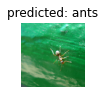

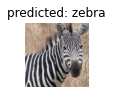

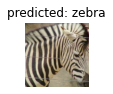

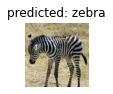

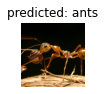

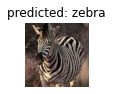

In [9]:
ms.visualize_model(model_ft, device=device, dataloaders=dataloaders, class_names=class_names)

In [10]:
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]]

target_class_tensors = torch.stack([ds.transform(img) for img in image_datasets['train']])
tcav_scores_w_zig_dot = mytcav.interpret(inputs=target_class_tensors,
                                         experimental_sets=experimental_sets,
                                         target=target_class_idx,
                                         n_steps=5)

ts.plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot, layers)

TypeError: Unexpected type <class 'tuple'>

In [ ]:
# Visualization of various concepts
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [ ]:
# Visualization of classes

# Visualize some of the images
fig, axs = plt.subplots(1, 6, figsize = (25, 5))
axs[0].imshow(zebra_imgs[40])
axs[1].imshow(zebra_imgs[41])
axs[2].imshow(ant_imgs[34])
axs[3].imshow(ant_imgs[31])
axs[4].imshow(bee_imgs[30])
axs[5].imshow(bee_imgs[31])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')
axs[5].axis('off')

plt.show()